In [8]:
import time
import psycopg2
import datetime
from config import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

## Establishing connection to Database

In [9]:
conn = None

try:
    # read connection parameters
    params = config()

    # connect to the PostgreSQL server
    print('Connecting to the PostgreSQL database...')
    conn = psycopg2.connect(**params)

    # create a cursor
    cur = conn.cursor()
        
    # execute a statement, display the PostgreSQL database server version
    print('PostgreSQL database version:')
    cur.execute('SELECT version()')
    db_version = cur.fetchone()
    print(db_version)
       
    # execute a statement, fech pv ids
    
    cur.execute('SELECT date,time, yield FROM daily_yield')
    result = cur.fetchall()
    
    # close the communication with the PostgreSQL
    cur.close()
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
    
finally:
    if conn is not None:
        conn.close()
        print('Database connection closed.')

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 13.0 (Debian 13.0-1.pgdg100+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit',)
Database connection closed.


In [11]:
print(result[0])

(datetime.date(2020, 7, 21), datetime.time(15, 15), Decimal('1660.00'))


## Data Preparation
Converting SQL values to Dataframe, then convert the time column to datetime column and convert yield to numeric values

In [12]:
import pandas
df= pandas.DataFrame(result, columns=['date','time','yield'])
print(df)

               date      time    yield
0        2020-07-21  15:15:00  1660.00
1        2020-07-21  15:20:00  3290.00
2        2020-07-21  15:25:00  4250.00
3        2020-07-21  15:30:00  4210.00
4        2020-07-21  15:35:00  4080.00
...             ...       ...      ...
3938765  2020-07-16  17:45:00   737.00
3938766  2020-07-16  17:50:00   550.00
3938767  2020-07-16  17:55:00   497.00
3938768  2020-07-16  18:00:00   514.00
3938769  2020-07-16  18:05:00   541.00

[3938770 rows x 3 columns]


In [13]:
#combining date and time column into one to convert it to datetime64 format
from datetime import datetime
df['date']=df.apply(lambda r : datetime.combine(r['date'],r['time']),1)

In [14]:
print(df)

                       date      time    yield
0       2020-07-21 15:15:00  15:15:00  1660.00
1       2020-07-21 15:20:00  15:20:00  3290.00
2       2020-07-21 15:25:00  15:25:00  4250.00
3       2020-07-21 15:30:00  15:30:00  4210.00
4       2020-07-21 15:35:00  15:35:00  4080.00
...                     ...       ...      ...
3938765 2020-07-16 17:45:00  17:45:00   737.00
3938766 2020-07-16 17:50:00  17:50:00   550.00
3938767 2020-07-16 17:55:00  17:55:00   497.00
3938768 2020-07-16 18:00:00  18:00:00   514.00
3938769 2020-07-16 18:05:00  18:05:00   541.00

[3938770 rows x 3 columns]


In [15]:
#Now, drop the time column and set the index to 'date'
df= df.drop(['time'], axis=1)
         

In [16]:
df= df.set_index('date')

In [17]:
print(df)

                       yield
date                        
2020-07-21 15:15:00  1660.00
2020-07-21 15:20:00  3290.00
2020-07-21 15:25:00  4250.00
2020-07-21 15:30:00  4210.00
2020-07-21 15:35:00  4080.00
...                      ...
2020-07-16 17:45:00   737.00
2020-07-16 17:50:00   550.00
2020-07-16 17:55:00   497.00
2020-07-16 18:00:00   514.00
2020-07-16 18:05:00   541.00

[3938770 rows x 1 columns]


In [18]:
#Values of yield is decimal, it's important to convert them to Numeric values to plot graphs etc
import pandas as pd
df["yield"] = pd.to_numeric(df["yield"])

In [19]:
print(df['yield'])

date
2020-07-21 15:15:00    1660.0
2020-07-21 15:20:00    3290.0
2020-07-21 15:25:00    4250.0
2020-07-21 15:30:00    4210.0
2020-07-21 15:35:00    4080.0
                        ...  
2020-07-16 17:45:00     737.0
2020-07-16 17:50:00     550.0
2020-07-16 17:55:00     497.0
2020-07-16 18:00:00     514.0
2020-07-16 18:05:00     541.0
Name: yield, Length: 3938770, dtype: float64


## Dataframe plotting and correlation plotting

<AxesSubplot:xlabel='date'>

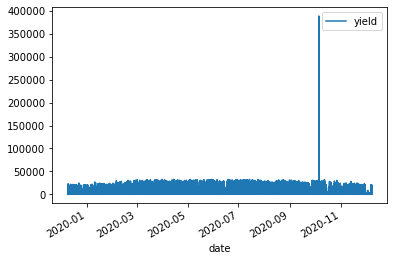

In [20]:
df.plot()

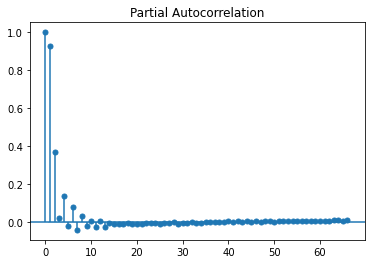

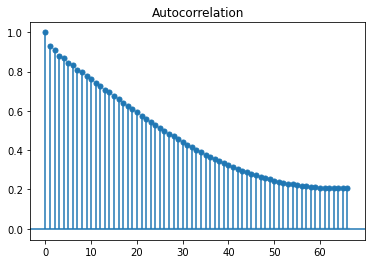

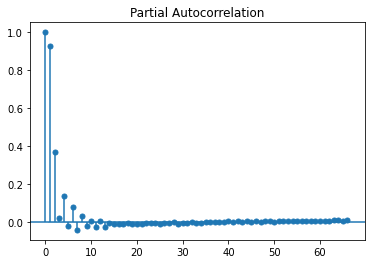

In [20]:
#Note: Due to large dataset,this took me 3 hours to run and plot correlation
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df)
plot_pacf(df)

## MODEL BUILDING- SARIMAX
Refrence for pdarima- https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
from statsmodels.tsa.arima_model import ARMA,ARIMA, ARMAResults, ARIMAResults

In [23]:
#using pmdarima to determine the best parameters (plag, order, qlag) 
#from pmdarima import auto_arima 
#auto_arima(df['yield'],seasonal=False).summary()

In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['yield'].values,order=(0,0,1))
model_fit= model.fit()
rmse = sqrt(mean_squared_error(df['yield'].values,model_fit.fittedvalues)) 
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2768.052
